# Generate cutting XML from exported results from QuPath

Modified from notebook **https://mannlabs.github.io/py-lmd/** by James Crichton

Images first annotated in Qupath, including calibration points selected and **named** (this is an option in the proprties of an annotation and is distinct from its classification) with **points tool** and called "calib1", "calib2" and "calib3".

Annotations exported as GeoJson file as a feature collection with **no compression**.

## <font color='blue'>1. Set parameters for your conversion</font>

For basic conversions (single classification, single well), **this is the only cell which requires any editing**.

Once completed you can "Run All Cells"



In [32]:
geojson_annotation_file="./Laser_Capture_Annotation_Conversion/Tissue_test_annotations.geojson" # geojson annotations file saved from QuPath
xml_output_file="./converted_annotations.xml" # destination for saving the converted output file for use on the LMD. End with ".xml"
annotation_classification="Tissue" # this is the classification name of the annotation object to be dissected
annotation_number=4 # how many of these annotations to dissect? Add number e.g. 1000. If all, set as "All"

## 2. Import libraries and define helper functions

In [33]:
# import required libraries
import json 
import geojson 
import geopandas
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import cm
from lmd.lib import Collection, Shape

In [43]:
#define helper functions

def get_calib_points(list_of_calibpoint_names, df):
    #create shape list
    pointlist = []
    for point_name in list_of_calibpoint_names:
        pointlist.append(df.loc[df['name'] == point_name, 'geometry'].values[0])

    #create coordinate list
    listarray = []
    for point in pointlist:
        listarray.append([point.x, point.y])
    nparray = np.array(listarray)

    return(nparray)

#returns dataframe with only polygon objects
def remove_non_polygons(df):
    import shapely

    df_filtered = df.loc[[type(x) == shapely.geometry.polygon.Polygon for x in df.geometry]]
    return(df_filtered)

#creates new column for coordenates in a list of list format
#assumes only polygons in dataframe
def replace_coords(df):
    df['coordinates_shape_exterior'] = np.nan
    df['coordinates_shape_exterior'] = df['coordinates_shape_exterior'].astype('object')

    for i in df.index:
        #get geometry object for row i
        geom = df.at[i, 'geometry']
        #list the coordinate points as tuples
        tmp = list(geom.exterior.coords)
        #transform list of tuples to list of lists and save to dataframe
        df.at[i,'coordinates_shape_exterior'] = [list(i) for i in tmp]

    return(df)

def nearest_neighbor_path(coords, start_index=0):
    coords = coords[:]  # copy so we don't modify original
    visited = [start_index]
    unvisited = set(range(len(coords))) - {start_index}

    while unvisited:
        last_index = visited[-1]
        nearest_index = min(
            unvisited,
            key=lambda i: math.hypot(
                coords[i][0] - coords[last_index][0],
                coords[i][1] - coords[last_index][1]
            )
        )
        visited.append(nearest_index)
        unvisited.remove(nearest_index)

    # Return ordered coordinates
    return [coords[i] for i in visited]



# Calculate distance travelled
# Unsorted coordinates
def dissection_path_length(coords):
    total_distance = sum(
        math.hypot(x2 - x1, y2 - y1)
        for (x1, y1), (x2, y2) in zip(coords, coords[1:])
    )
    return total_distance

## 3. Import annotations as geopandas dataframe and format


In [73]:
# Import annotations
df = geopandas.read_file(geojson_annotation_file)

# Find annotations for the calibration points
caliblist = get_calib_points(['calib1','calib2','calib3'],df)

# Clean up dataframe: Remove non-polygon shapes, extract polygon coordinates, and parse annotation for easier use
df_poly = remove_non_polygons(df)
df_poly = replace_coords(df_poly)

# Filter dataset to contain only the named annotation class
selected_index=[]
for index, row in df_poly.iterrows():
    if (row.loc["classification"] is not None):
        if (row.loc["classification"]["name"]==annotation_classification):
            selected_index.append(index)
            
selected_gdf=df_poly.loc[selected_index]

# If a set number of objects was requested, subset the dataset
if annotation_number!="All":
    selected_gdf=selected_gdf.head(annotation_number)#//.copy()
    
# Add centroid coordinates for path optimisation
selected_gdf["centroid_coords"] = [(geom.x, geom.y) for geom in selected_gdf.geometry.centroid] 

## 4. Improve path further by moving between nearest neighbours


In [71]:
# Sort dataset order
ordered_coords = nearest_neighbor_path(selected_gdf.centroid_coords, start_index=0)

#Caluclate change in distance
original_length=dissection_path_length(selected_gdf.centroid_coords)
print(f"Original dissection path length is {original_length:,.2f}px")

sorted_length=dissection_path_length(ordered_coords)
print(f"Sorted dissection path length is {sorted_length:,.2f}px")

relative_distance=(sorted_length/original_length)*100
print(f"Sorted distance is {relative_distance:,.2f}% of original distance")

Original dissection path length is 5,688,934.00px
Sorted dissection path length is 280,126.79px
Sorted distance is 4.92% of original distance


## 5. Generate shape collection for dissection

===== Collection Stats =====
Number of shapes: 1,000
Number of vertices: 28,940
Mean vertices: 29
Min vertices: 18
5% percentile vertices: 22
Median vertices: 28
95% percentile vertices: 38
Max vertices: 59
None


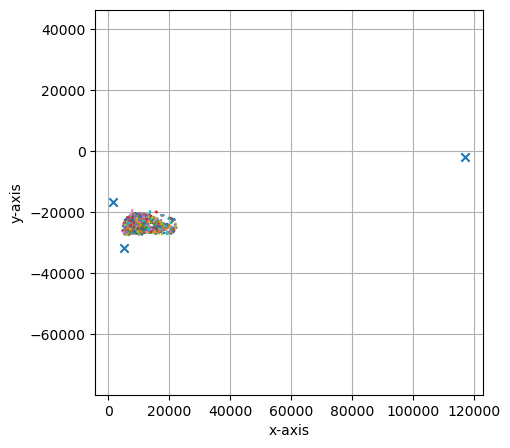

In [108]:
# Calibration points
shape_collection = Collection(calibration_points = caliblist)
shape_collection.orientation_transform = np.array([[1,0 ], [0,-1]])

# Annotations
for i in selected_gdf.index:
    shape_collection.new_shape(selected_gdf.loc[i,'coordinates_shape_exterior'], well = "well1") 

# Print some statistics on the shapes included in the collection and visualize results
print(shape_collection.stats())

# Plot 
shape_collection.plot(calibration = True)

## 6. Export to .xml file for LMD



In [25]:
shape_collection.save(xml_output_file)

[11716051.  -177419.]
[  528278. -3178769.]
[  152831. -1673412.]
